In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import clip
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns

In [2]:
device = torch.device("cuda")

In [3]:
class HMDataset(object):
    def __init__(self, images_path: str, annotation_path: str, image_transform=None, text_transform=None) -> None:
        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(".jsonl"), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)      

    def __len__(self):
        return self.annotation.shape[0]

    def __getitem__(self, index):
        img_path = os.path.join(self.images_path.split('img')[0], self.annotation.loc[index,"img"])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[index,"text"]
        label = self.annotation.loc[index,"label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, torch.tensor(label)


In [4]:
HOME = os.getenv("HOME")
model, preprocess = clip.load("ViT-L/14@336px")

train_dataset = HMDataset(
        f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/",
        os.path.join(f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/",'train_updated.jsonl'),
        image_transform=preprocess,
        text_transform=lambda texts: clip.tokenize(texts, truncate=True),
    )

memotion_dataset = HMDataset(
        f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/",
        os.path.join(f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/",'label_memotion.jsonl'),
        image_transform=preprocess,
        text_transform=lambda texts: clip.tokenize(texts, truncate=True),
    )


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=24)
memotion_dataloader = DataLoader(memotion_dataset, batch_size=64, shuffle=False, num_workers=24)

In [6]:
image_features, text_features, labels_all = [], [], []
for i, data in  enumerate(train_dataloader):
    images, texts, labels = data
    images, texts, labels = images.to(device), texts.to(device), labels.to(device)
    with torch.no_grad():
        img_extract = model.encode_image(images)
        text_extract = model.encode_text(texts.squeeze())
    image_features.append(img_extract)
    text_features.append(text_extract)
    labels_all.append(labels)

In [7]:
labels_all = torch.hstack(labels_all)
len(labels_all)

8600

In [8]:
m_image_features, m_text_features = [], []
m_labels_all = []
for i, data in  enumerate(memotion_dataloader):
    images, texts, labels = data
    images, texts, labels = images.to(device), texts.to(device), labels.to(device)
    with torch.no_grad():
        img_extract = model.encode_image(images)
        text_extract = model.encode_text(texts.squeeze())
    m_image_features.append(img_extract)
    m_text_features.append(text_extract)
    m_labels_all.append(labels)

In [9]:
m_labels_all = torch.hstack(m_labels_all)
len(m_labels_all)

328

In [10]:
image_features = torch.vstack(image_features)
text_features = torch.vstack(text_features)
fused_images_texts = torch.hstack((image_features, text_features))

In [11]:
image_features.shape, text_features.shape, fused_images_texts.shape

(torch.Size([8600, 768]), torch.Size([8600, 768]), torch.Size([8600, 1536]))

In [12]:
image_features = image_features.cpu().detach().numpy()
text_features = text_features.cpu().detach().numpy()
fused_images_texts = fused_images_texts.cpu().detach().numpy()
labels_all = labels_all.cpu().detach().numpy()

In [13]:
m_image_features = torch.vstack(m_image_features)
m_text_features = torch.vstack(m_text_features)
m_fused_images_texts = torch.hstack((m_image_features, m_text_features))

In [14]:
m_image_features = m_image_features.cpu().detach().numpy()
m_text_features = m_text_features.cpu().detach().numpy()
m_fused_images_texts = m_fused_images_texts.cpu().detach().numpy()
m_labels_all = m_labels_all.cpu().detach().numpy()

In [15]:
m_image_features.shape, m_text_features.shape, m_fused_images_texts.shape

((328, 768), (328, 768), (328, 1536))

### T-SNE plots for image features only

In [16]:
X_tsne_hate = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(image_features)

[Text(0.5, 1.0, 'Hate Meme T-SNE - Image Features')]

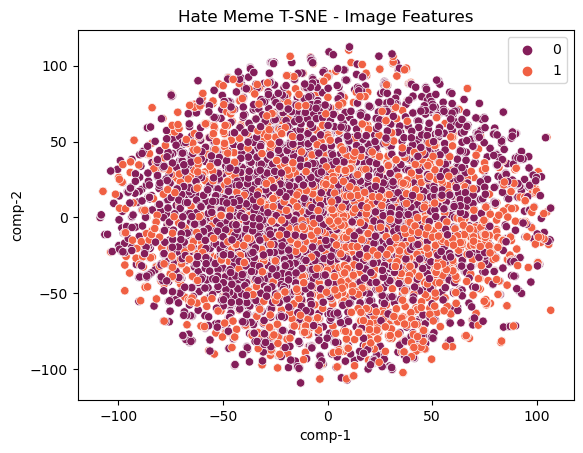

In [17]:
df_hate = pd.DataFrame()
df_hate['label'] = labels_all
df_hate['comp-1'] = X_tsne_hate[:, 0]
df_hate['comp-2'] = X_tsne_hate[:, 1]

sns.scatterplot(x='comp-1', y='comp-2', hue=df_hate.label.tolist(),
                palette=sns.color_palette('rocket', 2), 
                data=df_hate).set(title='Hate Meme T-SNE - Image Features')

In [18]:
X_tsne_memo = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(m_image_features)

[Text(0.5, 1.0, 'Memotion T-SNE - Image Features')]

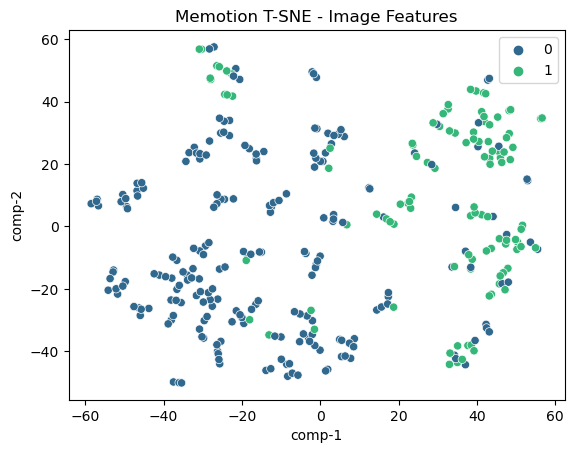

In [19]:
df_memo = pd.DataFrame()
df_memo['label'] = m_labels_all
df_memo['comp-1'] = X_tsne_memo[:, 0]
df_memo['comp-2'] = X_tsne_memo[:, 1]

sns.scatterplot(x='comp-1', y='comp-2', hue=df_memo.label.tolist(),
                palette=sns.color_palette('viridis', 2), 
                data=df_memo).set(title='Memotion T-SNE - Image Features')

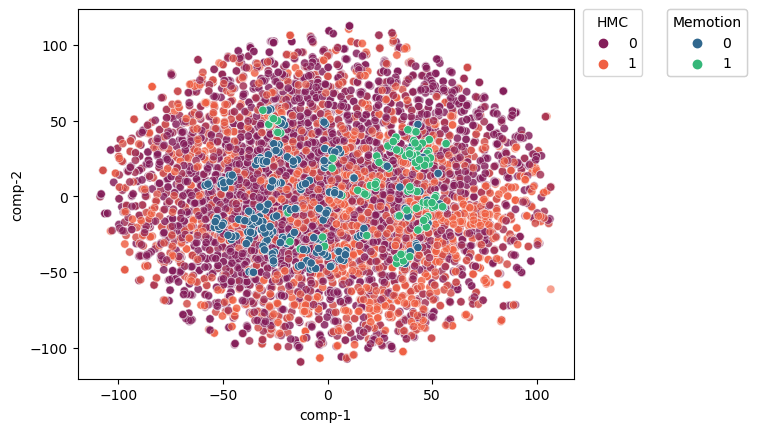

In [20]:
fig, ax = plt.subplots()

a = sns.scatterplot(x='comp-1', y='comp-2', hue = df_hate.label.tolist(),
                palette=sns.color_palette('rocket', 2), 
                data=df_hate, alpha =0.6, ax=ax)
legend_a = plt.legend(title = 'HMC', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

b = sns.scatterplot(x='comp-1', y='comp-2', hue = df_memo.label.tolist(),
                palette=sns.color_palette('viridis', 2), 
                data=df_memo,ax=ax)

h,l = b.get_legend_handles_labels()
legend_b = plt.legend(h[2:4],l[2:4], title = 'Memotion', bbox_to_anchor=(1.35, 1), loc=1, borderaxespad=0)

ax.add_artist(legend_a)
ax.add_artist(legend_b)

### T-SNE plots for text features only 


In [21]:
X_tsne_hate = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(text_features)

[Text(0.5, 1.0, 'Hate Meme T-SNE - Text Features')]

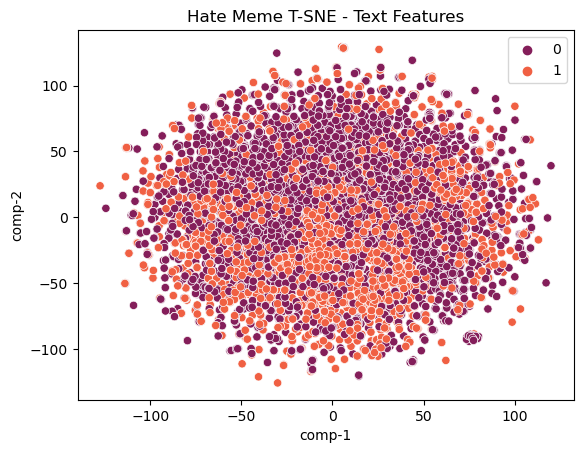

In [22]:
df_hate = pd.DataFrame()
df_hate['label'] = labels_all
df_hate['comp-1'] = X_tsne_hate[:, 0]
df_hate['comp-2'] = X_tsne_hate[:, 1]

sns.scatterplot(x='comp-1', y='comp-2', hue=df_hate.label.tolist(),
                palette=sns.color_palette('rocket', 2), 
                data=df_hate).set(title='Hate Meme T-SNE - Text Features')

In [23]:
X_tsne_memo = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(m_text_features)

[Text(0.5, 1.0, 'Memotion T-SNE - Text Features')]

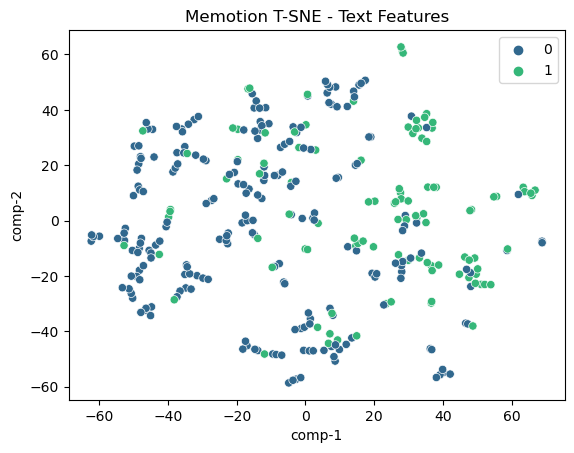

In [24]:
df_memo = pd.DataFrame()
df_memo['label'] = m_labels_all
df_memo['comp-1'] = X_tsne_memo[:, 0]
df_memo['comp-2'] = X_tsne_memo[:, 1]

sns.scatterplot(x='comp-1', y='comp-2', hue=df_memo.label.tolist(),
                palette=sns.color_palette('viridis', 2), 
                data=df_memo).set(title='Memotion T-SNE - Text Features')

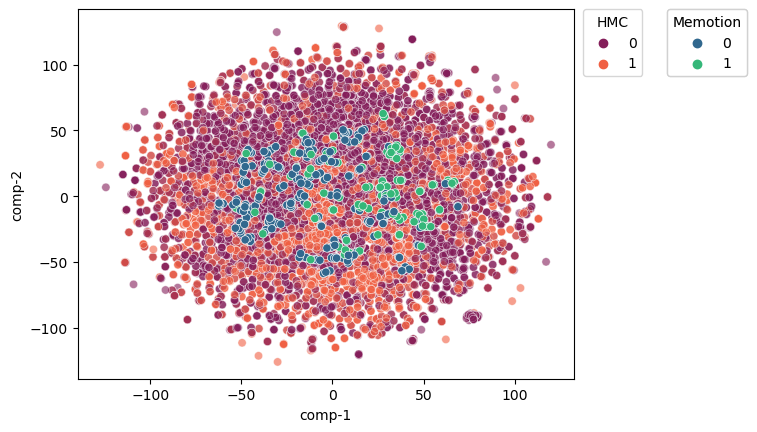

In [25]:
fig, ax = plt.subplots()

a = sns.scatterplot(x='comp-1', y='comp-2', hue = df_hate.label.tolist(),
                palette=sns.color_palette('rocket', 2), 
                data=df_hate, alpha =0.6, ax=ax)
legend_a = plt.legend(title = 'HMC', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

b = sns.scatterplot(x='comp-1', y='comp-2', hue = df_memo.label.tolist(),
                palette=sns.color_palette('viridis', 2), 
                data=df_memo,ax=ax)

h,l = b.get_legend_handles_labels()
legend_b = plt.legend(h[2:4],l[2:4], title = 'Memotion', bbox_to_anchor=(1.35, 1), loc=1, borderaxespad=0)

ax.add_artist(legend_a)
ax.add_artist(legend_b)

### T-SNE plots for both image and text features 

In [26]:
X_tsne_hate = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(fused_images_texts)

[Text(0.5, 1.0, 'Hate Meme T-SNE - Image and Text Features')]

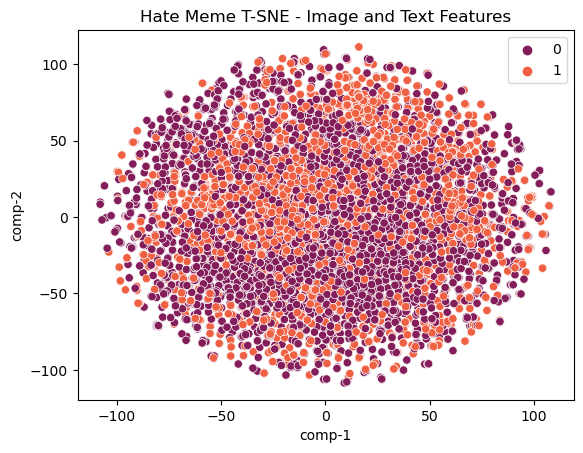

In [27]:
df_hate = pd.DataFrame()
df_hate['label'] = labels_all
df_hate['comp-1'] = X_tsne_hate[:, 0]
df_hate['comp-2'] = X_tsne_hate[:, 1]

sns.scatterplot(x='comp-1', y='comp-2', hue=df_hate.label.tolist(),
                palette=sns.color_palette('rocket', 2), 
                data=df_hate).set(title='Hate Meme T-SNE - Image and Text Features')

In [28]:
X_tsne_memo = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(m_fused_images_texts)

[Text(0.5, 1.0, 'Memotion T-SNE - Image and Text Features')]

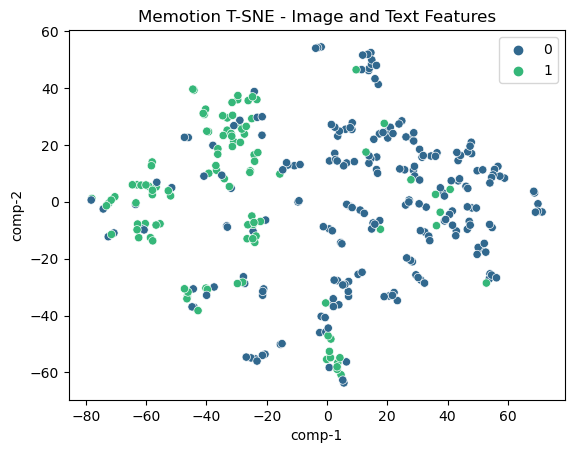

In [29]:
df_memo = pd.DataFrame()
df_memo['label'] = m_labels_all
df_memo['comp-1'] = X_tsne_memo[:, 0]
df_memo['comp-2'] = X_tsne_memo[:, 1]

sns.scatterplot(x='comp-1', y='comp-2', hue=df_memo.label.tolist(),
                palette=sns.color_palette('viridis', 2), 
                data=df_memo).set(title='Memotion T-SNE - Image and Text Features')

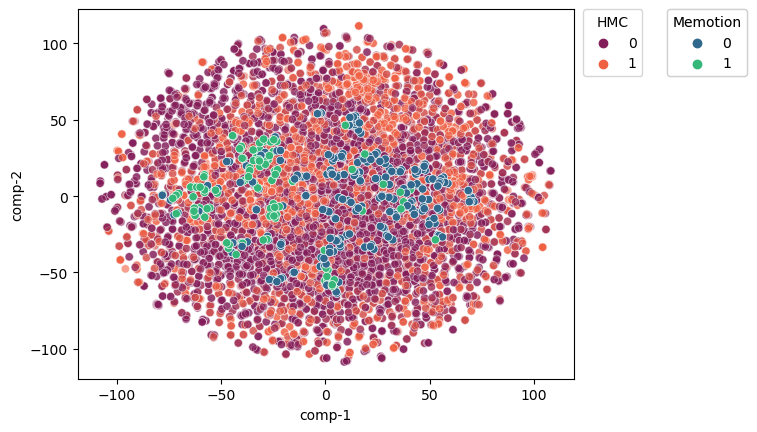

In [30]:
fig, ax = plt.subplots()

a = sns.scatterplot(x='comp-1', y='comp-2', hue = df_hate.label.tolist(),
                palette=sns.color_palette('rocket', 2), 
                data=df_hate, alpha =0.6, ax=ax)
legend_a = plt.legend(title = 'HMC', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

b = sns.scatterplot(x='comp-1', y='comp-2', hue = df_memo.label.tolist(),
                palette=sns.color_palette('viridis', 2), 
                data=df_memo,ax=ax)

h,l = b.get_legend_handles_labels()
legend_b = plt.legend(h[2:4],l[2:4], title = 'Memotion', bbox_to_anchor=(1.35, 1), loc=1, borderaxespad=0)

ax.add_artist(legend_a)
ax.add_artist(legend_b)